In [1]:
# 4.1

%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, np, npx
npx.set_np()

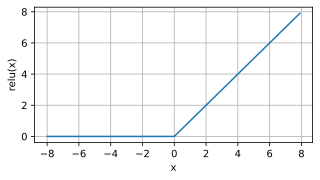

In [2]:
x= np.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = npx.relu(x)
d2l.plot(x, y, 'x', 'relu(x)', figsize=(5, 2.5))

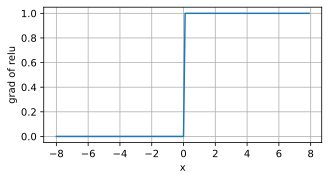

In [3]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

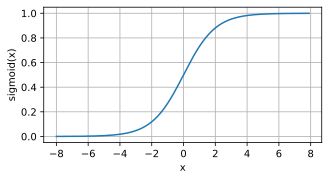

In [4]:
with autograd.record():
    y = npx.sigmoid(x)
d2l.plot(x, y, 'x', 'sigmoid(x)', figsize=(5, 2.5))

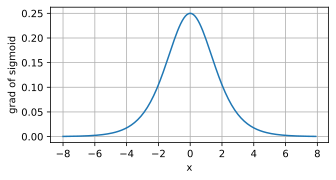

In [5]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

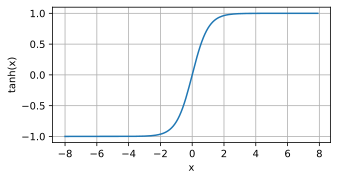

In [6]:
with autograd.record():
    y = np.tanh(x)
d2l.plot(x, y, 'x', 'tanh(x)', figsize=(5, 2.5))

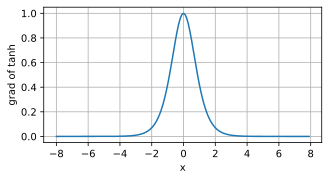

In [7]:
y.backward()
d2l.plot(x, x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

In [15]:
# 4.1 MLP from scratch

from d2l import mxnet as d2l
from mxnet import gluon, np, npx
npx.set_np()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [16]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens))
b1 = np.zeros(num_hiddens)
W2 = np.random.normal(scale=0.01, size=(num_hiddens, num_outputs))
b2 = np.zeros(num_outputs)
params = [W1, b1, W2, b2]
for param in params:
    param.attach_grad()

In [17]:
# relu rectified linear unit
def relu(X):
    return np.maximum(X, 0)

In [18]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(np.dot(X, W1) + b1)
    return np.dot(H, W2) + b2

In [19]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

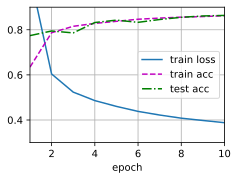

In [20]:
num_epochs, lr = 10, 0.1
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
    lambda batch_size: d2l.sgd(params, lr, batch_size))

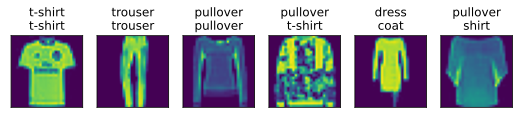

In [21]:
d2l.predict_ch3(net, test_iter)

In [22]:
# 4.3 Consise MLP

from d2l import mxnet as d2l
from mxnet import gluon, init, npx
from mxnet.gluon import nn

npx.set_np()

In [29]:
# Adding an exta layr to the network to see effect
# need to do 20 epochs to get similar results.
net = nn.Sequential()
net.add(nn.Dense(256, activation='relu'),
        nn.Dense(10))
net.add(nn.Dense(256, activation='relu'),
        nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

In [30]:
batch_size, lr, num_epochs = 256, 0.1, 20
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

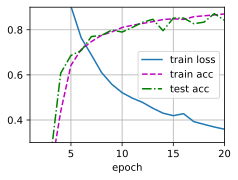

In [31]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [33]:
# 4.4.4 Polynomial regression

from d2l import mxnet as d2l
from mxnet import gluon, np, npx
from mxnet.gluon import nn
import math
npx.set_np()


In [34]:
max_degree = 20 # Maximum degree of the polynomial
n_train, n_test = 100, 100 # Training and test dataset sizes
true_w = np.zeros(max_degree) # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # `gamma(n)` = (n-1)!

    # Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [35]:
features[:2], poly_features[:2, :], labels[:2]

(array([[-0.01691294],
        [-0.84104633]]),
 array([[ 1.00000000e+00, -1.69129446e-02,  1.43023848e-04,
         -8.06318155e-07,  3.40930373e-09, -1.15322725e-11,
          3.25074474e-14, -7.85423807e-17,  1.66047874e-19,
         -3.12039800e-22,  5.27751249e-25, -8.11438775e-28,
          1.14365162e-30, -1.48788602e-33,  1.79746675e-36,
         -2.02669657e-39,  2.14258535e-42, -2.80259693e-45,
          0.00000000e+00, -0.00000000e+00],
        [ 1.00000000e+00, -8.41046333e-01,  3.53679478e-01,
         -9.91536081e-02,  2.08481941e-02, -3.50685930e-03,
          4.91571904e-04, -5.90621021e-05,  6.20924493e-06,
         -5.80251481e-07,  4.88018372e-08, -3.73132769e-09,
          2.61518307e-10, -1.69191536e-11,  1.01641373e-12,
         -5.69900640e-14,  2.99570545e-15, -1.48207486e-16,
          6.92496418e-18, -3.06537651e-19]]),
 array([4.8408947, 2.3226955]))

In [36]:
def evaluate_loss(net, data_iter, loss): #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2) # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(d2l.reduce_sum(l), l.size)
    return metric[0] / metric[1]

In [37]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                                is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
            evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

weight: [[ 4.99474    1.219855  -3.4057174  5.562954 ]]


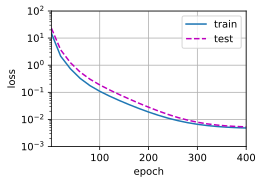

In [38]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.3740163 3.8840873]]


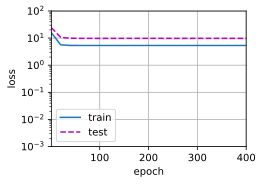

In [39]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9336104   1.2933221  -3.1611798   5.047044   -0.45693362  1.4705927
  -0.04902135  0.14721426  0.0076171  -0.03179427  0.06244214 -0.06391709
  -0.04332707  0.01200172 -0.0165735   0.0644184  -0.06589391  0.06300638
  -0.06946429 -0.06225638]]


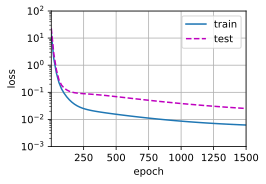

In [40]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

In [41]:
# 4.5.2

%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

In [42]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = np.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [43]:
# 4.5.3 Weight decay from scratch
def init_params():
    w = np.random.normal(scale=1, size=(num_inputs, 1))
    b = np.zeros(1)
    w.attach_grad()
    b.attach_grad()
    return [w, b]

In [44]:
def l2_penalty(w):
    return (w**2).sum() / 2

In [45]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                # The L2 norm penalty term has been added, and broadcasting
                # makes `l2_penalty(w)` a vector whose length is `batch_size`
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', np.linalg.norm(w))

L2 norm of w: 13.605665


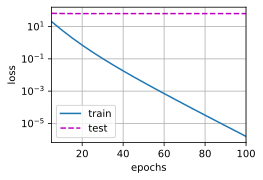

In [46]:
# Train without regularization 
train(lambd=0)

L2 norm of w: 0.34680954


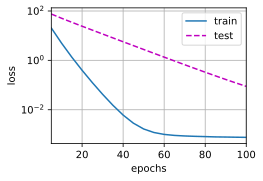

In [47]:
# Train with decay
train(lambd=3)

In [48]:
# .4.5.4 Concise weight decay implementation

def train_concise(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    loss = gluon.loss.L2Loss()
    num_epochs, lr = 100, 0.003
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr, 'wd': wd})
    # The bias parameter has not decayed. Bias names generally end with "bias"
    net.collect_params('.*bias').setattr('wd_mult', 0)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                         d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', np.linalg.norm(net[0].weight.data()))

L2 norm of w: 14.300876


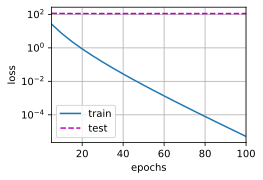

In [49]:
train_concise(0)

L2 norm of w: 0.3537202


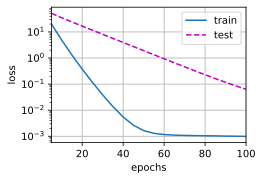

In [50]:
train_concise(3)

In [51]:
# 4.6.4 Dropout from scratch

from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return np.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = np.random.uniform(0, 1, X.shape) > dropout
    return mask.astype(np.float32) * X / (1.0 - dropout)

In [52]:
X = np.arange(16).reshape(2, 8)
print(dropout_layer(X, 0))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1))

[[ 0.  1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14. 15.]]
[[ 0.  0.  4.  0.  0. 10. 12.  0.]
 [16. 18.  0.  0. 24. 26. 28.  0.]]
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [53]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hiddens1))
b1 = np.zeros(num_hiddens1)
W2 = np.random.normal(scale=0.01, size=(num_hiddens1, num_hiddens2))
b2 = np.zeros(num_hiddens2)
W3 = np.random.normal(scale=0.01, size=(num_hiddens2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

In [54]:
dropout1, dropout2 = 0.2, 0.5

def net(X):
    X = X.reshape(-1, num_inputs)
    H1 = npx.relu(np.dot(X, W1) + b1)
    # Use dropout only when training the model
    if autograd.is_training():
        # Add a dropout layer after the first fully connected layer
        H1 = dropout_layer(H1, dropout1)
    H2 = npx.relu(np.dot(H1, W2) + b2)
    if autograd.is_training():
        # Add a dropout layer after the second fully connected layer
        H2 = dropout_layer(H2, dropout2)
    return np.dot(H2, W3) + b3

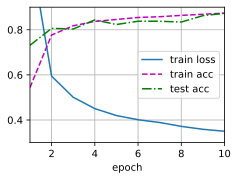

In [55]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,
              lambda batch_size: d2l.sgd(params, lr, batch_size))


In [56]:
# 4.6.5 Concise implementation of dropout
net = nn.Sequential()
net.add(nn.Dense(256, activation="relu"),
    # Add a dropout layer after the first fully connected layer
    nn.Dropout(dropout1),
    nn.Dense(256, activation="relu"),
    # Add a dropout layer after the second fully connected layer
    nn.Dropout(dropout2),
    nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

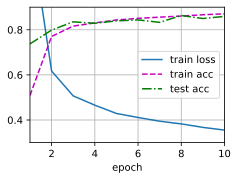

In [57]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)